In [15]:
#Importing packages, setting style for charts

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd as pt
import warnings

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [16]:
# Reading in the dataframes

movie_info    = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t') # mi
tmdb          = pd.read_csv('zippedData/tmdb.movies.csv.gz') #tmdb
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz') # mb
movie_gross   = pd.read_csv("zippedData/bom.movie_gross.csv.gz") # mg
reviews       = pd.read_csv("zippedData/rt.reviews.tsv.gz", error_bad_lines=False, sep='\t', encoding= 'unicode_escape')

In [17]:
# Reading in the im.db database

# Filtering the database based directors who are still alive
conn = sqlite3.connect('zippedData/im.db/im.db')

q = """

WITH living_directors AS(
SELECT primary_title, start_year, genres, primary_name, death_year, primary_profession 
FROM movie_basics mb
INNER JOIN directors d
    ON mb.movie_id = d.movie_id
INNER JOIN persons p
    ON d.person_id = p.person_id
WHERE primary_profession LIKE '%director%'
GROUP BY mb.movie_id
HAVING p.death_year is NULL
)

SELECT * FROM living_directors

"""

alive_directors = pd.read_sql(q, conn)

# 1. Cleaning Data

1a. The Movie Database (tmdb)

In [18]:
# Adding a column that concantenates the title and release date of the movie for dataframe merging with movie_budgets dataframe
tmdb_title = tmdb['original_title']
tmdb_date = tmdb['release_date']
tmdb['title_and_year'] = tmdb_title + ' ' + tmdb_date.apply(lambda x: x[:4])

# Removing duplicates from tmdb
tmdb = tmdb.drop_duplicates(subset='id', keep='first')
tmdb = tmdb.drop_duplicates(subset='title_and_year', keep='first')

1b. The Numbers Movie Budgets (movie_budgets)

In [19]:
# Adding a matching column in movie_budgets to prepare for merge with tmdb dataframe
movie_budgets_title = movie_budgets['movie']
movie_budgets_date = movie_budgets['release_date']
movie_budgets['title_and_year'] = movie_budgets_title + ' ' + movie_budgets_date.apply(lambda x: x[-4:])

# Creating numeric columns to represent revenue and budget
movie_budgets['revenue'] = movie_budgets['worldwide_gross'].replace('[\$,]','', regex=True).astype(float)
movie_budgets['budget'] = movie_budgets['production_budget'].replace('[\$,]','', regex=True).astype(float)

# Removing duplicates
movie_budgets = movie_budgets.drop_duplicates(subset='title_and_year', keep='first')

1c. IMDB (living_directors_df)

In [20]:
# Converting the sql database into a dataframe
alive_directors = pd.DataFrame(alive_directors)

# Adding a matching column in alive_directors dataframe to prepare for merge with tmdb and movie_budgets dataframes
alive_directors_title = alive_directors['primary_title']
alive_directors_year = alive_directors['start_year']
alive_directors['title_and_year'] = alive_directors_title + ' ' + alive_directors_year.apply(lambda x: str(x))

In [21]:
# Merging the tmdb, movie_budgets, and alive_directors dataframes
tmdb_n_budgets = pd.merge(movie_budgets, tmdb, how='inner', on='title_and_year')
tmdb_n_budgets = pd.merge(tmdb_n_budgets, alive_directors, how='inner', on='title_and_year')

"""
Filtering to rows that have greater than $0 in revenue. 
Research showed that many of these movies were released directly to streaming services, not theatres
"""
tmdb_n_budgets = tmdb_n_budgets.loc[tmdb_n_budgets['revenue'] != 0]
tmdb_n_budgets

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,title_and_year,revenue,budget,Unnamed: 0,...,release_date_y,title,vote_average,vote_count,primary_title,start_year,genres,primary_name,death_year,primary_profession
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",Pirates of the Caribbean: On Stranger Tides 2011,1.045664e+09,410600000.0,2470,...,2011-05-20,Pirates of the Caribbean: On Stranger Tides,6.4,8571,Pirates of the Caribbean: On Stranger Tides,2011,"Action,Adventure,Fantasy",Rob Marshall,None,"director,miscellaneous,producer"
1,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",Avengers: Age of Ultron 2015,1.403014e+09,330600000.0,14169,...,2015-05-01,Avengers: Age of Ultron,7.3,13457,Avengers: Age of Ultron,2015,"Action,Adventure,Sci-Fi",Joss Whedon,None,"writer,producer,director"
2,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",Avengers: Infinity War 2018,2.048134e+09,300000000.0,23811,...,2018-04-27,Avengers: Infinity War,8.3,13948,Avengers: Infinity War,2018,"Action,Adventure,Sci-Fi",Joe Russo,None,"producer,director,writer"
3,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209",Justice League 2017,6.559452e+08,300000000.0,20623,...,2017-11-17,Justice League,6.2,7510,Justice League,2017,"Action,Adventure,Fantasy",Zack Snyder,None,"producer,director,writer"
4,10,"Nov 6, 2015",Spectre,"$300,000,000","$200,074,175","$879,620,923",Spectre 2015,8.796209e+08,300000000.0,14175,...,2015-11-06,Spectre,6.4,6719,Spectre,2015,"Action,Adventure,Thriller",Sam Mendes,None,"producer,director,miscellaneous"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,6,"Dec 31, 2011",Absentia,"$70,000",$0,"$8,555",Absentia 2011,8.555000e+03,70000.0,2614,...,2011-03-03,Absentia,5.9,175,Absentia,2011,"Drama,Horror,Mystery",Mike Flanagan,None,"editor,writer,director"
1259,6,"Dec 31, 2011",Absentia,"$70,000",$0,"$8,555",Absentia 2011,8.555000e+03,70000.0,2614,...,2011-03-03,Absentia,5.9,175,Absentia,2011,Sci-Fi,Steven Young,None,"director,actor,writer"
1262,20,"Jul 31, 2015",Counting,"$50,000","$8,374","$8,374",Counting 2015,8.374000e+03,50000.0,16645,...,2015-07-31,Counting,8.3,3,Counting,2015,Documentary,Jem Cohen,None,"director,cinematographer,editor"
1265,32,"Feb 11, 2011",Raymond Did It,"$40,000","$3,632","$3,632",Raymond Did It 2011,3.632000e+03,40000.0,3576,...,2011-03-27,Raymond Did It,3.7,8,Raymond Did It,2011,Horror,Travis Legge,None,"editor,writer,director"


# 2. Linear Regression

### In this section we conducted linear regression tests on the movie's budget, vote average, and revenue to see how they are related

In [22]:
budget = tmdb_n_budgets['budget']
vote_average = tmdb_n_budgets['vote_average']

model = sm.OLS(vote_average, sm.add_constant(budget))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           vote_average   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     25.00
Date:                Wed, 21 Jun 2023   Prob (F-statistic):           6.57e-07
Time:                        09:54:58   Log-Likelihood:                -1461.0
No. Observations:                1199   AIC:                             2926.
Df Residuals:                    1197   BIC:                             2936.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2253      0.031    199.417      0.000       6.164       6.287
budget      2.078e-09   4.16e-10      5.000      0.000    1.26e-09    2.89e-09
==============================================================================
Omnibus:                       21.579   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.566
Skew:                          -0.266   Prob(JB):                     4.63e-06
Kurtosis:                       3.457   Cond. No.                     9.92e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.92e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

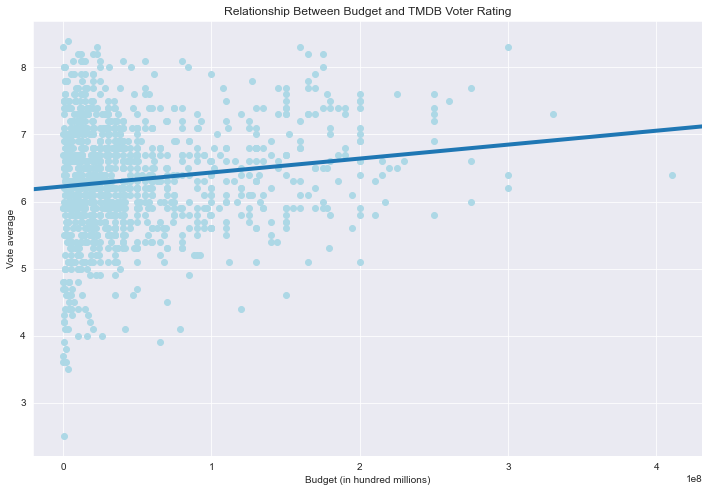

In [23]:
# Plotting the vote_average vs. budget
fig, ax=plt.subplots(figsize=(12,8))
ax.scatter(budget, vote_average, color='lightblue')
ax.set_xlabel('Budget (in hundred millions)')
ax.set_ylabel('Vote average')
ax.set_title('Relationship Between Budget and TMDB Voter Rating')
sm.graphics.abline_plot(model_results=results, ax=ax, linewidth=4);

In [24]:
budget = tmdb_n_budgets['budget']
revenue = tmdb_n_budgets['revenue']
model=sm.OLS(revenue, sm.add_constant(budget))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     2006.
Date:                Wed, 21 Jun 2023   Prob (F-statistic):          4.25e-258
Time:                        09:54:58   Log-Likelihood:                -24278.
No. Observations:                1199   AIC:                         4.856e+04
Df Residuals:                    1197   BIC:                         4.857e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.101e+06   5.74e+06     -1.411      0.159   -1.94e+07    3.16e+06
budget         3.4224      0.076     44.788      0.000       3.273       3.572
==============================================================================
Omnibus:                      570.121   Durbin-Watson:                   1.425
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6152.926
Skew:                           1.922   Prob(JB):                         0.00
Kurtosis:                      13.411   Cond. No.                     9.92e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.92e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

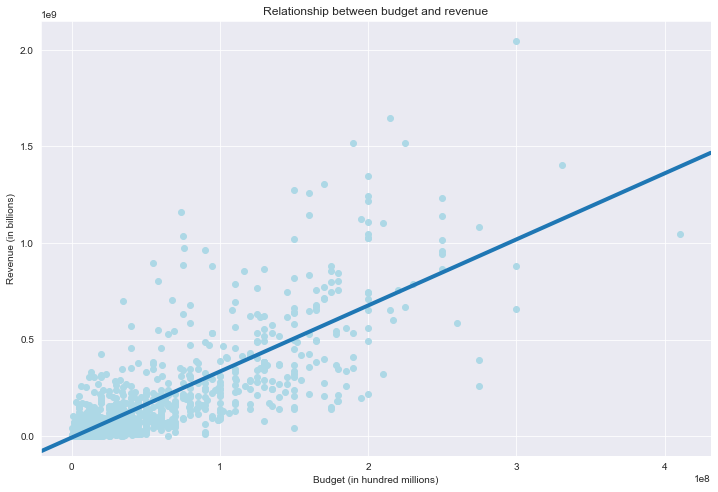

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(budget, revenue, color='lightblue')
ax.set_xlabel('Budget (in hundred millions)')
ax.set_ylabel('Revenue (in billions)')
ax.set_title('Relationship between budget and revenue')
sm.graphics.abline_plot(model_results=results, ax=ax, linewidth=4);

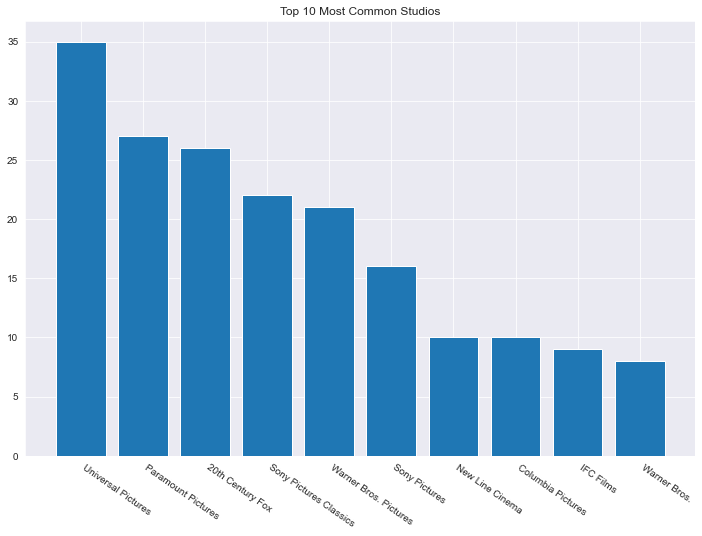

In [26]:
top_10_studio = movie_info['studio'].value_counts()[:10].index
top_10_studio_counts = movie_info['studio'].value_counts()[:10].values

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(top_10_studio, top_10_studio_counts)
ax.set_xticklabels(top_10_studio, rotation=-35, ha='left')
ax.set_title('Top 10 Most Common Studios');

In [27]:
tmdb_n_budgets['year'] = tmdb_n_budgets['release_date_y'].apply(lambda x: x[:4]).astype(int)
revenue_by_year = tmdb_n_budgets.groupby('year')['revenue'].mean()

In [28]:
X = revenue_by_year.index
y = revenue_by_year.values
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     25.95
Date:                Wed, 21 Jun 2023   Prob (F-statistic):            0.00141
Time:                        09:54:58   Log-Likelihood:                -160.21
No. Observations:                   9   AIC:                             324.4
Df Residuals:                       7   BIC:                             324.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.939e+10   3.84e+09     -5.051      0.001   -2.85e+10   -1.03e+10
x1          9.706e+06   1.91e+06      5.094      0.001     5.2e+06    1.42e+07
==============================================================================
Omnibus:                        0.661   Durbin-Watson:                   2.242
Prob(Omnibus):                  0.719   Jarque-Bera (JB):                0.528
Skew:                          -0.046   Prob(JB):                        0.768
Kurtosis:                       1.817   Cond. No.                     1.57e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
# Reset index due to dropping rows
tmdb_n_budgets.reset_index(inplace=True)

# Remove unnecessary columns
tmdb_n_budgets.drop(['index', 'id_x', 'id_y', 'Unnamed: 0'], axis=1, inplace=True)

tmdb_n_budgets.tail()

,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,title_and_year,revenue,budget,genre_ids,original_language,...,title,vote_average,vote_count,primary_title,start_year,genres,primary_name,death_year,primary_profession,year
1194,"Dec 31, 2011",Absentia,"$70,000",$0,"$8,555",Absentia 2011,8555.0,70000.0,"[9648, 27, 53]",en,...,Absentia,5.9,175,Absentia,2011,"Drama,Horror,Mystery",Mike Flanagan,None,"editor,writer,director",2011
1195,"Dec 31, 2011",Absentia,"$70,000",$0,"$8,555",Absentia 2011,8555.0,70000.0,"[9648, 27, 53]",en,...,Absentia,5.9,175,Absentia,2011,Sci-Fi,Steven Young,None,"director,actor,writer",2011
1196,"Jul 31, 2015",Counting,"$50,000","$8,374","$8,374",Counting 2015,8374.0,50000.0,[99],en,...,Counting,8.3,3,Counting,2015,Documentary,Jem Cohen,None,"director,cinematographer,editor",2015
1197,"Feb 11, 2011",Raymond Did It,"$40,000","$3,632","$3,632",Raymond Did It 2011,3632.0,40000.0,[27],en,...,Raymond Did It,3.7,8,Raymond Did It,2011,Horror,Travis Legge,None,"editor,writer,director",2011
1198,"Sep 1, 2015",Exeter,"$25,000",$0,"$489,792",Exeter 2015,489792.0,25000.0,"[53, 27]",en,...,Exeter,4.7,121,Exeter,2015,"Horror,Mystery,Thriller",Marcus Nispel,None,"director,producer,writer",2015


In [30]:
tmdb_genres={
'Action':        28,
'Adventure':       12,
'Animation':       16,
'Comedy':          35,
'Crime':           80,
'Documentary':     99,
'Drama':           18,
'Family':          10751,
'Fantasy':         14,
'History':         36,
'Horror':          27,
'Music':           10402,
'Mystery':        9648,
'Romance':         10749,
'Science Fiction': 878,
'TV Movie':        10770,
'Thriller':        53,
'War':             10752,
'Western':         37}

# Reverses the key and values of the tmdb_genres dictionary
tmdb_genres_swap = {y:x for x,y in tmdb_genres.items()}

# Converts the ids in genre_ids to a list from a string and replaces the id with its corresponding genre
tmdb_n_budgets['genre_ids'] = tmdb_n_budgets['genre_ids'].apply(lambda x: [tmdb_genres_swap.get(int(id), 'X') for id in x.strip('[]').split(',') if len(id) != 0])

# Resetting index and dropping duplicate columns again after removing rows
tmdb_n_budgets.reset_index(inplace=True)
tmdb_n_budgets.drop(['index'], axis=1, inplace=True)

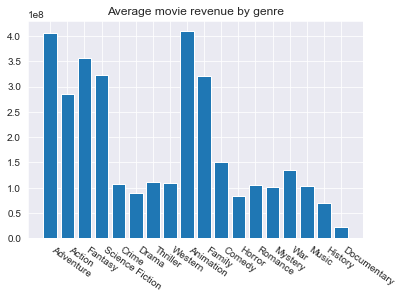

In [31]:
genre_n_revenue = {}

"""
Loops through each movie and appends a list of revenues associated with each of the movies' genres
The dictionary will result in keys representing the genres and the values being a list of revenues
"""
for row in tmdb_n_budgets.index:
    g_ids = tmdb_n_budgets.iloc[row]['genre_ids']
    rev = tmdb_n_budgets.iloc[row]['revenue']
    for g in g_ids:
        if g in genre_n_revenue.keys():
            genre_n_revenue[g] = np.append(genre_n_revenue[g], rev)
        else:
            genre_n_revenue[g] = np.array([rev])

genre_and_revenue_average = {}

# Adds a key (genre) and value (average revenue) to the genre_and_revenue_average dictionary
for g in genre_n_revenue.keys():
    genre_and_revenue_average[g] = genre_n_revenue[g].mean()

fig, ax = plt.subplots()
ax.bar(genre_and_revenue_average.keys(), genre_and_revenue_average.values())
ax.set_title('Average movie revenue by genre')
ax.set_xticklabels(genre_and_revenue_average.keys(), rotation=-35, ha='left');

In [32]:
# Checking to see if genre has a statistically significant impact on revenue
stats.f_oneway(*genre_n_revenue.values())

F_onewayResult(statistic=40.97620817119495, pvalue=7.816240190206602e-123)

Since the p-value is extremely small and less than 0.05, we conclude that genre does have a statistically significant impact on revenue.

We will now replace the genre ids with the actual genre names, and then analyze the ratio of revenue to budget by genre.

In [33]:
tmdb_n_budgets['revenue_to_budget'] = tmdb_n_budgets['revenue'] / tmdb_n_budgets['budget']

In [34]:
genre_rois = {}

for row in tmdb_n_budgets.index:
    g_ids = tmdb_n_budgets.iloc[row]['genre_ids']
    rtb = tmdb_n_budgets.iloc[row]['revenue_to_budget']
    for g in g_ids:
        if g in genre_rois.keys():
            genre_rois[g] = np.append(genre_rois[g], rtb)
        else:
            genre_rois[g] = np.array([rtb])

genre_rois_average = {}
for g in genre_rois.keys():
    genre_rois_average[g] = genre_rois[g].mean()

genre_rois_average

{'Adventure': 3.302647916910832,
 'Action': 2.863567618535614,
 'Fantasy': 3.3896963801155846,
 'Science Fiction': 3.502434406838799,
 'Crime': 2.331518630911596,
 'Drama': 3.3570224678056593,
 'Thriller': 5.55208189235727,
 'Western': 1.51974943101423,
 'Animation': 4.055268233565061,
 'Family': 3.5626043654348876,
 'Comedy': 3.4188435562112667,
 'Horror': 11.60866077125604,
 'Romance': 3.984986001121255,
 'Mystery': 4.600039345541699,
 'War': 2.4808892376702047,
 'Music': 3.7158731200973905,
 'History': 2.554444494572822,
 'Documentary': 3.103574026856342}

#### Does genre have a statistically significant impact on return on investment?
Before we make recommendations on which genres to invest in, we must first determine whether genre is statistically significant in our data when it comes to predicting return on investment.

In [35]:
stats.f_oneway(*genre_rois.values())

F_onewayResult(statistic=4.452007039668321, pvalue=2.978902853807239e-09)

Since our p-value is less than 0.05, we conclude that there is a statistically significant difference in return on investment by genre. Therefore we will conduct further analysis to see which genres are the best investments.

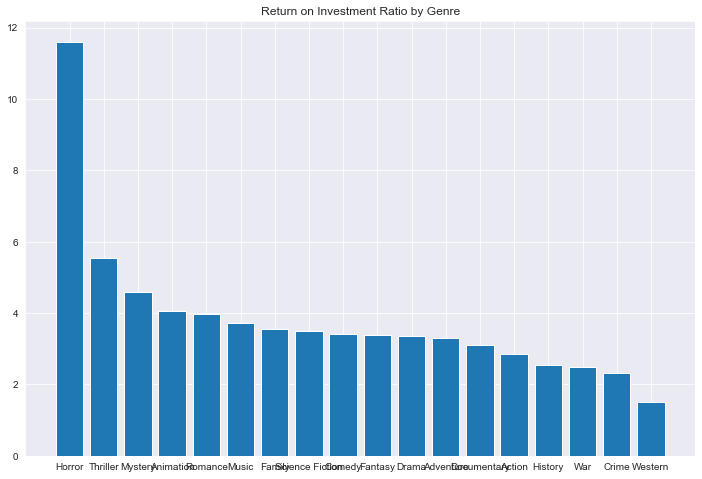

In [36]:
genre_ids = list(genre_rois_average.keys())
rois = list(genre_rois_average.values())
genres_and_rois = pd.DataFrame(data=rois, index=genre_ids, columns={'Return on Investment'})
genres_and_rois.sort_values(by='Return on Investment', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(genres_and_rois.index, genres_and_rois['Return on Investment'])
ax.set_title('Return on Investment Ratio by Genre');

We can see that genre 27 has the highest return on investment, followed by genres 9648 and 53.

## What about for current movies only? Are the results different?
Our investor asked us to look specifically at how movies are currently doing in the box office, so we will filter the results further to movies released after 2017.

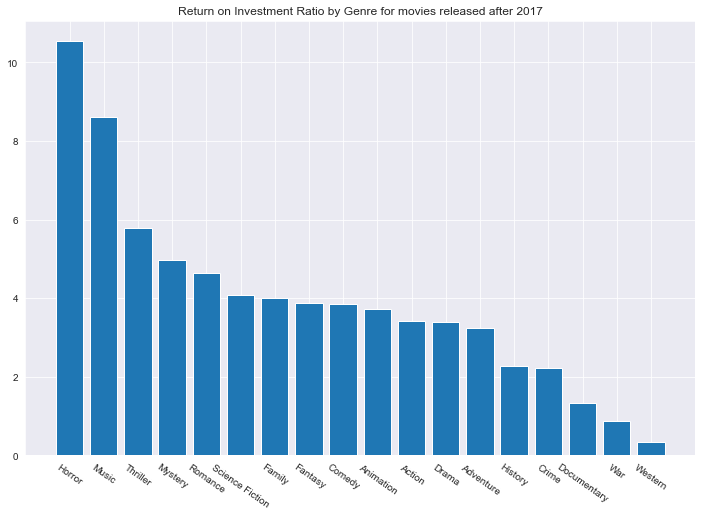

In [37]:
#repeating the same steps as above, but for new movies only

new_movies=tmdb_n_budgets.loc[tmdb_n_budgets['year']>2017]
new_movies.reset_index(inplace=True)

new_genre_rois={}
for row in new_movies.index:
    g_ids=new_movies.iloc[row]['genre_ids']
    rtb=new_movies.iloc[row]['revenue_to_budget']
    for g in g_ids:
        if g in new_genre_rois.keys():
            new_genre_rois[g]=np.append(new_genre_rois[g], rtb)
        else:
            new_genre_rois[g]=np.array([rtb])

new_genre_rois_average={}
for g in new_genre_rois.keys():
    new_genre_rois_average[g]=new_genre_rois[g].mean()

assert(stats.f_oneway(*new_genre_rois.values())[1]<0.05)

new_movies_genres_and_rois=pd.DataFrame(index=new_genre_rois_average.keys(), data=new_genre_rois_average.values(), columns={'Return on Investment'})
new_movies_genres_and_rois.sort_values(by='Return on Investment', ascending=False, inplace=True)

fig, ax=plt.subplots(figsize=(12,8))
ax.bar(new_movies_genres_and_rois.index, new_movies_genres_and_rois['Return on Investment'])
ax.set_title('Return on Investment Ratio by Genre for movies released after 2017')
ax.set_xticklabels(new_movies_genres_and_rois.index, rotation=-35, ha='center');


Horror still has the highest return on investment, although the gap is not as wide when filtered to new movies only. Music and romance have also done well recently in the box office.

The top genres we recommend are Horror, Music, Romance, Thriller, and Mystery.